# Table of Contents

## - Import libraries and define functions + Initial setup

## - Pre-process files

## - Make graphs

## - Make output GTFs

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
import os
import glob


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    dff = df.copy()
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = dff.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        dff["gene_id"] = dff.index
        cols = list(dff.columns)
        cols = [cols[-1]] + cols[:-1]
        dff = dff[cols]
        dff.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = dff.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    dff.columns = list_new_names
    
    return dff 

In [3]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [4]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):
    
    dff = df.copy()

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = dff.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = dff.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    cpm_columns = {}

    for col in count_columns:
        rounded_col = round(dff[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        cpm_columns[cpm_name] = round(((rounded_col/(rounded_col.sum())) * 1000000), 2)

    new_data = {**dff.round(2).to_dict(orient='series'), **cpm_columns}
    dff = pd.DataFrame(new_data)

    return dff

In [5]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## - Pre-process files

In [6]:
## Open up unique reads
df_counts_gtex_88 = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-88_discovery/bambu_discovery/counts_transcript.txt",
                              sep="\t")

## Fix column names
df_counts_gtex_88 = fix_column_names(df_counts_gtex_88, is_gene=False)

In [7]:
## Open up unique reads
df_counts_gtex_107 = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt",
                              sep="\t")

## Fix column names
df_counts_gtex_107 = fix_column_names(df_counts_gtex_107, is_gene=False)

In [8]:
## Open up unique reads
df_counts_ours_88 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-88_discovery/bambu_discovery/counts_transcript.txt",
                              sep="\t")

## Fix column names
df_counts_ours_88 = fix_column_names(df_counts_ours_88, is_gene=False)

In [9]:
## Open up unique reads
df_counts_ours_107 = pd.read_csv("../../../data/raw/1st_rebuttal_data/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt",
                              sep="\t")

## Fix column names
df_counts_ours_107 = fix_column_names(df_counts_ours_107, is_gene=False)

In [10]:
## Import and parse through extended annotations
ref_gtex_88 = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-88_discovery/bambu_discovery//extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_gtex_88 = ref_gtex_88.loc[~ref_gtex_88["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_gtex_88 = parse_df_columns(ref_gtex_88, is_ref=False)

## Only keep transcripts
ref_gtex_88 = ref_gtex_88.loc[ref_gtex_88["type"] == "transcript"].copy()

In [11]:
## Import and parse through extended annotations
ref_gtex_107 = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_gtex_107 = ref_gtex_107.loc[~ref_gtex_107["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_gtex_107 = parse_df_columns(ref_gtex_107, is_ref=False)

## Only keep transcripts
ref_gtex_107 = ref_gtex_107.loc[ref_gtex_107["type"] == "transcript"].copy()

In [12]:
## Import and parse through extended annotations
ref_ours_88 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-88_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_ours_88 = ref_ours_88.loc[~ref_ours_88["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_ours_88 = parse_df_columns(ref_ours_88, is_ref=False)

## Only keep transcripts
ref_ours_88 = ref_ours_88.loc[ref_ours_88["type"] == "transcript"].copy()

In [13]:
## Import and parse through extended annotations
ref_ours_107 = pd.read_csv("../../../data/raw/1st_rebuttal_data/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_ours_107 = ref_ours_107.loc[~ref_ours_107["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_ours_107 = parse_df_columns(ref_ours_107, is_ref=False)

## Only keep transcripts
ref_ours_107 = ref_ours_107.loc[ref_ours_107["type"] == "transcript"].copy()

In [14]:
## Calculate CPM and drop count columns
df_counts_gtex_88 = calculate_cpm(df_counts_gtex_88, is_gene=False)
df_counts_gtex_107 = calculate_cpm(df_counts_gtex_107, is_gene=False)
df_counts_ours_88 = calculate_cpm(df_counts_ours_88, is_gene=False)
df_counts_ours_107 = calculate_cpm(df_counts_ours_107, is_gene=False)


df_counts_gtex_88 = df_counts_gtex_88[df_counts_gtex_88.columns.drop(list(df_counts_gtex_88.filter(regex='counts')))].copy()
df_counts_gtex_107 = df_counts_gtex_107[df_counts_gtex_107.columns.drop(list(df_counts_gtex_107.filter(regex='counts')))].copy()
df_counts_ours_88 = df_counts_ours_88[df_counts_ours_88.columns.drop(list(df_counts_ours_88.filter(regex='counts')))].copy()
df_counts_ours_107 = df_counts_ours_107[df_counts_ours_107.columns.drop(list(df_counts_ours_107.filter(regex='counts')))].copy()

In [15]:
## Add chromosomes
df_counts_gtex_88 = df_counts_gtex_88.merge(ref_gtex_88[["transcript_id", "chr"]], how="inner")
df_counts_gtex_107 = df_counts_gtex_107.merge(ref_gtex_107[["transcript_id", "chr"]], how="inner")
df_counts_ours_88 = df_counts_ours_88.merge(ref_ours_88[["transcript_id", "chr"]], how="inner")
df_counts_ours_107 = df_counts_ours_107.merge(ref_ours_107[["transcript_id", "chr"]], how="inner")

In [16]:
## Calculate median CPM
df_counts_gtex_88["median_CPM"] = df_counts_gtex_88[df_counts_gtex_88.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_counts_gtex_107["median_CPM"] = df_counts_gtex_107[df_counts_gtex_107.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_counts_ours_88["median_CPM"] = df_counts_ours_88[df_counts_ours_88.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_counts_ours_107["median_CPM"] = df_counts_ours_107[df_counts_ours_107.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [17]:
## Only keep new transcripts
df_counts_gtex_88_all = df_counts_gtex_88.loc[df_counts_gtex_88["transcript_id"].str.startswith("Bambu")].copy()
df_counts_gtex_107_all = df_counts_gtex_107.loc[df_counts_gtex_107["transcript_id"].str.startswith("Bambu")].copy()
df_counts_ours_88_all = df_counts_ours_88.loc[df_counts_ours_88["transcript_id"].str.startswith("Bambu")].copy()
df_counts_ours_107_all = df_counts_ours_107.loc[df_counts_ours_107["transcript_id"].str.startswith("Bambu")].copy()

In [18]:
## Get transcript ids for all new transcripts
df_counts_gtex_88_all_ids = df_counts_gtex_88_all["transcript_id"].copy()
df_counts_gtex_107_all_ids = df_counts_gtex_107_all["transcript_id"].copy()
df_counts_ours_88_all_ids = df_counts_ours_88_all["transcript_id"].copy()
df_counts_ours_107_all_ids = df_counts_ours_107_all["transcript_id"].copy()

In [19]:
## Only keep high-confidence transcripts
df_counts_gtex_88_hf = df_counts_gtex_88_all.loc[df_counts_gtex_88_all["median_CPM"] > 1].copy()
df_counts_gtex_107_hf = df_counts_gtex_107_all.loc[df_counts_gtex_107_all["median_CPM"] > 1].copy()
df_counts_ours_88_hf = df_counts_ours_88_all.loc[df_counts_ours_88_all["median_CPM"] > 1].copy()
df_counts_ours_107_hf = df_counts_ours_107_all.loc[df_counts_ours_107_all["median_CPM"] > 1].copy()

In [20]:
## Remove mitochondrial novel transcripts
df_counts_gtex_88_hf = df_counts_gtex_88_hf.loc[df_counts_gtex_88_hf["chr"] != "MT"].copy()
df_counts_gtex_107_hf = df_counts_gtex_107_hf.loc[df_counts_gtex_107_hf["chr"] != "MT"].copy()
df_counts_ours_88_hf = df_counts_ours_88_hf.loc[df_counts_ours_88_hf["chr"] != "MT"].copy()
df_counts_ours_107_hf = df_counts_ours_107_hf.loc[df_counts_ours_107_hf["chr"] != "MT"].copy()

In [21]:
## Import full length counts matrix

df_mito_gtex_88_hf =  pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-88_discovery/bambu_discovery/fullLengthCounts_transcript.txt",
                              sep="\t")

## Fix column names
df_mito_gtex_88_hf = fix_column_names(df_mito_gtex_88_hf, is_gene=False)

## Get mediann full counts
df_mito_gtex_88_hf["median_counts"] = round(df_mito_gtex_88_hf[df_mito_gtex_88_hf.columns[2:]].median(axis=1))

## Only keep high-confidence
df_mito_gtex_88_hf = df_mito_gtex_88_hf.loc[df_mito_gtex_88_hf["median_counts"] >= 40].copy()

## Novel mito HF transcript ids
df_mito_gtex_88_hf = df_mito_gtex_88_hf.loc[df_mito_gtex_88_hf["transcript_id"].str.startswith("BambuTx")].copy()
df_mito_gtex_88_hf_ids = df_mito_gtex_88_hf["transcript_id"].copy()

In [22]:
## Import full length counts matrix

df_mito_gtex_107_hf =  pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-107_discovery/bambu_discovery/fullLengthCounts_transcript.txt",
                              sep="\t")

## Fix column names
df_mito_gtex_107_hf = fix_column_names(df_mito_gtex_107_hf, is_gene=False)

## Get mediann full counts
df_mito_gtex_107_hf["median_counts"] = round(df_mito_gtex_107_hf[df_mito_gtex_107_hf.columns[2:]].median(axis=1))

## Only keep high-confidence
df_mito_gtex_107_hf = df_mito_gtex_107_hf.loc[df_mito_gtex_107_hf["median_counts"] >= 40].copy()

## Novel mito HF transcript ids
df_mito_gtex_107_hf = df_mito_gtex_107_hf.loc[df_mito_gtex_107_hf["transcript_id"].str.startswith("BambuTx")].copy()
df_mito_gtex_107_hf_ids = df_mito_gtex_107_hf["transcript_id"].copy()

In [23]:
## Import full length counts matrix

df_mito_ours_88_hf =  pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-88_discovery/bambu_discovery/fullLengthCounts_transcript.txt",
                              sep="\t")

## Fix column names
df_mito_ours_88_hf = fix_column_names(df_mito_ours_88_hf, is_gene=False)

## Get mediann full counts
df_mito_ours_88_hf["median_counts"] = round(df_mito_ours_88_hf[df_mito_ours_88_hf.columns[2:]].median(axis=1))

## Only keep high-confidence
df_mito_ours_88_hf = df_mito_ours_88_hf.loc[df_mito_ours_88_hf["median_counts"] >= 40].copy()

## Novel mito HF transcript ids
df_mito_ours_88_hf = df_mito_ours_88_hf.loc[df_mito_ours_88_hf["transcript_id"].str.startswith("BambuTx")].copy()
df_mito_ours_88_hf_ids = df_mito_ours_88_hf["transcript_id"].copy()

In [24]:
## Import full length counts matrix

df_mito_ours_107_hf =  pd.read_csv("../../../data/raw/1st_rebuttal_data/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/fullLengthCounts_transcript.txt",
                              sep="\t")

## Fix column names
df_mito_ours_107_hf = fix_column_names(df_mito_ours_107_hf, is_gene=False)

## Get mediann full counts
df_mito_ours_107_hf["median_counts"] = round(df_mito_ours_107_hf[df_mito_ours_107_hf.columns[2:]].median(axis=1))

## Only keep high-confidence
df_mito_ours_107_hf = df_mito_ours_107_hf.loc[df_mito_ours_107_hf["median_counts"] >= 40].copy()

## Novel mito HF transcript ids
df_mito_ours_107_hf = df_mito_ours_107_hf.loc[df_mito_ours_107_hf["transcript_id"].str.startswith("BambuTx")].copy()
df_mito_ours_107_hf_ids = df_mito_ours_107_hf["transcript_id"].copy()

In [25]:
## Only keep high-confidence MT transcripts in matrix
df_counts_gtex_88_mito_hf = df_counts_gtex_88_all.loc[df_counts_gtex_88_all["transcript_id"].isin(df_mito_gtex_88_hf)].copy()
df_counts_gtex_88_mito_hf = df_counts_gtex_88_mito_hf.loc[df_counts_gtex_88_mito_hf["chr"] == "MT"].copy()
df_counts_gtex_88_hf = pd.concat([df_counts_gtex_88_hf, df_counts_gtex_88_mito_hf])

In [26]:
## Only keep high-confidence MT transcripts in matrix
df_counts_gtex_107_mito_hf = df_counts_gtex_107_all.loc[df_counts_gtex_107_all["transcript_id"].isin(df_mito_gtex_107_hf)].copy()
df_counts_gtex_107_mito_hf = df_counts_gtex_107_mito_hf.loc[df_counts_gtex_107_mito_hf["chr"] == "MT"].copy()
df_counts_gtex_107_hf = pd.concat([df_counts_gtex_107_hf, df_counts_gtex_107_mito_hf])

In [27]:
## Only keep high-confidence MT transcripts in matrix
df_counts_ours_88_mito_hf = df_counts_ours_88_all.loc[df_counts_ours_88_all["transcript_id"].isin(df_mito_ours_88_hf_ids)].copy()
df_counts_ours_88_mito_hf = df_counts_ours_88_mito_hf.loc[df_counts_ours_88_mito_hf["chr"] == "MT"].copy()
df_counts_ours_88_hf = pd.concat([df_counts_ours_88_hf, df_counts_ours_88_mito_hf])

In [28]:
## Only keep high-confidence MT transcripts in matrix
df_counts_ours_107_mito_hf = df_counts_ours_107_all.loc[df_counts_ours_107_all["transcript_id"].isin(df_mito_ours_107_hf_ids)].copy()
df_counts_ours_107_mito_hf = df_counts_ours_107_mito_hf.loc[df_counts_ours_107_mito_hf["chr"] == "MT"].copy()
df_counts_ours_107_hf = pd.concat([df_counts_ours_107_hf, df_counts_ours_107_mito_hf])

In [31]:
## Print out the number of new transcripts

print("New transcripts (No Filter) GTEx BA9 ENSEMBL 88:", df_counts_gtex_88_all["transcript_id"].nunique())
print("New transcripts (No Filter) GTEx BA9 ENSEMBL 107:", df_counts_gtex_107_all["transcript_id"].nunique())
print("New transcripts (No Filter) OURS ENSEMBL 88:", df_counts_ours_88_all["transcript_id"].nunique())
print("New transcripts (No Filter) OURS ENSEMBL 107:", df_counts_ours_107_all["transcript_id"].nunique())


print()

print("New high-confidence transcripts GTEx BA9 ENSEMBL 88:", df_counts_gtex_88_hf["transcript_id"].nunique())
print("New high-confidence transcripts GTEx BA9 ENSEMBL 107:", df_counts_gtex_107_hf["transcript_id"].nunique())
print("New high-confidence transcripts OURS ENSEMBL 88:", df_counts_ours_88_hf["transcript_id"].nunique())
print("New high-confidence transcripts OURS ENSEMBL 107:", df_counts_ours_107_hf["transcript_id"].nunique())

New transcripts (No Filter) GTEx BA9 ENSEMBL 88: 1128
New transcripts (No Filter) GTEx BA9 ENSEMBL 107: 828
New transcripts (No Filter) OURS ENSEMBL 88: 3407
New transcripts (No Filter) OURS ENSEMBL 107: 3428

New high-confidence transcripts GTEx BA9 ENSEMBL 88: 704
New high-confidence transcripts GTEx BA9 ENSEMBL 107: 496
New high-confidence transcripts OURS ENSEMBL 88: 812
New high-confidence transcripts OURS ENSEMBL 107: 700


In [32]:
## Get transcript ids for hf new transcripts
df_counts_gtex_88_hf_ids = df_counts_gtex_88_hf["transcript_id"].copy()
df_counts_gtex_107_hf_ids = df_counts_gtex_107_hf["transcript_id"].copy()
df_counts_ours_88_hf_ids = df_counts_ours_88_hf["transcript_id"].copy()
df_counts_ours_107_hf_ids = df_counts_ours_107_hf["transcript_id"].copy()

In [33]:
## Define the types of discovery
df_counts_gtex_88_all.loc[df_counts_gtex_88_all["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_gtex_88_all.loc[~df_counts_gtex_88_all["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_gtex_88_all.loc[df_counts_gtex_88_all["chr"] == "MT", "Type"] = "New from mito"

df_counts_gtex_88_all_nfn = df_counts_gtex_88_all.loc[df_counts_gtex_88_all["Type"] == "New from new"].copy()
df_counts_gtex_88_all_nfk = df_counts_gtex_88_all.loc[df_counts_gtex_88_all["Type"] == "New from known"].copy()
df_counts_gtex_88_all_nfm = df_counts_gtex_88_all.loc[df_counts_gtex_88_all["Type"] == "New from mito"].copy()

In [34]:
## Define the types of discovery
df_counts_gtex_107_all.loc[df_counts_gtex_107_all["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_gtex_107_all.loc[~df_counts_gtex_107_all["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_gtex_107_all.loc[df_counts_gtex_107_all["chr"] == "MT", "Type"] = "New from mito"

df_counts_gtex_107_all_nfn = df_counts_gtex_107_all.loc[df_counts_gtex_107_all["Type"] == "New from new"].copy()
df_counts_gtex_107_all_nfk = df_counts_gtex_107_all.loc[df_counts_gtex_107_all["Type"] == "New from known"].copy()
df_counts_gtex_107_all_nfm = df_counts_gtex_107_all.loc[df_counts_gtex_107_all["Type"] == "New from mito"].copy()

In [35]:
## Define the types of discovery
df_counts_ours_88_all.loc[df_counts_ours_88_all["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_ours_88_all.loc[~df_counts_ours_88_all["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_ours_88_all.loc[df_counts_ours_88_all["chr"] == "MT", "Type"] = "New from mito"

df_counts_ours_88_all_nfn = df_counts_ours_88_all.loc[df_counts_ours_88_all["Type"] == "New from new"].copy()
df_counts_ours_88_all_nfk = df_counts_ours_88_all.loc[df_counts_ours_88_all["Type"] == "New from known"].copy()
df_counts_ours_88_all_nfm = df_counts_ours_88_all.loc[df_counts_ours_88_all["Type"] == "New from mito"].copy()

In [36]:
## Define the types of discovery
df_counts_ours_107_all.loc[df_counts_ours_107_all["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_ours_107_all.loc[~df_counts_ours_107_all["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_ours_107_all.loc[df_counts_ours_107_all["chr"] == "MT", "Type"] = "New from mito"

df_counts_ours_107_all_nfn = df_counts_ours_107_all.loc[df_counts_ours_107_all["Type"] == "New from new"].copy()
df_counts_ours_107_all_nfk = df_counts_ours_107_all.loc[df_counts_ours_107_all["Type"] == "New from known"].copy()
df_counts_ours_107_all_nfm = df_counts_ours_107_all.loc[df_counts_ours_107_all["Type"] == "New from mito"].copy()

In [37]:
## Define the types of discovery
df_counts_gtex_88_hf.loc[df_counts_gtex_88_hf["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_gtex_88_hf.loc[~df_counts_gtex_88_hf["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_gtex_88_hf.loc[df_counts_gtex_88_hf["chr"] == "MT", "Type"] = "New from mito"

df_counts_gtex_88_hf_nfn = df_counts_gtex_88_hf.loc[df_counts_gtex_88_hf["Type"] == "New from new"].copy()
df_counts_gtex_88_hf_nfk = df_counts_gtex_88_hf.loc[df_counts_gtex_88_hf["Type"] == "New from known"].copy()
df_counts_gtex_88_hf_nfm = df_counts_gtex_88_hf.loc[df_counts_gtex_88_hf["Type"] == "New from mito"].copy()

In [38]:
## Define the types of discovery
df_counts_gtex_107_hf.loc[df_counts_gtex_107_hf["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_gtex_107_hf.loc[~df_counts_gtex_107_hf["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_gtex_107_hf.loc[df_counts_gtex_107_hf["chr"] == "MT", "Type"] = "New from mito"

df_counts_gtex_107_hf_nfn = df_counts_gtex_107_hf.loc[df_counts_gtex_107_hf["Type"] == "New from new"].copy()
df_counts_gtex_107_hf_nfk = df_counts_gtex_107_hf.loc[df_counts_gtex_107_hf["Type"] == "New from known"].copy()
df_counts_gtex_107_hf_nfm = df_counts_gtex_107_hf.loc[df_counts_gtex_107_hf["Type"] == "New from mito"].copy()

In [39]:
## Define the types of discovery
df_counts_ours_88_hf.loc[df_counts_ours_88_hf["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_ours_88_hf.loc[~df_counts_ours_88_hf["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_ours_88_hf.loc[df_counts_ours_88_hf["chr"] == "MT", "Type"] = "New from mito"

df_counts_ours_88_hf_nfn = df_counts_ours_88_hf.loc[df_counts_ours_88_hf["Type"] == "New from new"].copy()
df_counts_ours_88_hf_nfk = df_counts_ours_88_hf.loc[df_counts_ours_88_hf["Type"] == "New from known"].copy()
df_counts_ours_88_hf_nfm = df_counts_ours_88_hf.loc[df_counts_ours_88_hf["Type"] == "New from mito"].copy()

In [40]:
## Define the types of discovery
df_counts_ours_107_hf.loc[df_counts_ours_107_hf["gene_id"].str.startswith("Bambu"), "Type"] = "New from new"
df_counts_ours_107_hf.loc[~df_counts_ours_107_hf["gene_id"].str.startswith("Bambu"), "Type"] =  "New from known"
df_counts_ours_107_hf.loc[df_counts_ours_107_hf["chr"] == "MT", "Type"] = "New from mito"

df_counts_ours_107_hf_nfn = df_counts_ours_107_hf.loc[df_counts_ours_107_hf["Type"] == "New from new"].copy()
df_counts_ours_107_hf_nfk = df_counts_ours_107_hf.loc[df_counts_ours_107_hf["Type"] == "New from known"].copy()
df_counts_ours_107_hf_nfm = df_counts_ours_107_hf.loc[df_counts_ours_107_hf["Type"] == "New from mito"].copy()

## - Make graphs

In [41]:
## Make master no filter dataset for plots

df_counts_gtex_88_all["source"] = "GTEx BA9 ENSEMBL 88"
df_counts_gtex_88_all = df_counts_gtex_88_all[["transcript_id", "Type", "source"]]

df_counts_gtex_107_all["source"] = "GTEx BA9 ENSEMBL 107"
df_counts_gtex_107_all = df_counts_gtex_107_all[["transcript_id", "Type", "source"]]
                                              
df_counts_ours_88_all["source"] = "OURS ENSEMBL 88"
df_counts_ours_88_all = df_counts_ours_88_all[["transcript_id", "Type", "source"]]

df_counts_ours_107_all["source"] = "OURS ENSEMBL 107"
df_counts_ours_107_all = df_counts_ours_107_all[["transcript_id", "Type", "source"]]

df_all = pd.concat([df_counts_gtex_88_all, df_counts_gtex_107_all, df_counts_ours_88_all, df_counts_ours_107_all])

In [42]:
## Make master HF dataset for plots

df_counts_gtex_88_hf["source"] = "GTEx BA9 ENSEMBL 88"
df_counts_gtex_88_hf = df_counts_gtex_88_hf[["transcript_id", "Type", "source"]]

df_counts_gtex_107_hf["source"] = "GTEx BA9 ENSEMBL 107"
df_counts_gtex_107_hf = df_counts_gtex_107_hf[["transcript_id", "Type", "source"]]
                                              
df_counts_ours_88_hf["source"] = "OURS ENSEMBL 88"
df_counts_ours_88_hf = df_counts_ours_88_hf[["transcript_id", "Type", "source"]]

df_counts_ours_107_hf["source"] = "OURS ENSEMBL 107"
df_counts_ours_107_hf = df_counts_ours_107_hf[["transcript_id", "Type", "source"]]

df_hf = pd.concat([df_counts_gtex_88_hf, df_counts_gtex_107_hf, df_counts_ours_88_hf, df_counts_ours_107_hf])

In [43]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (120*mm, 120*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

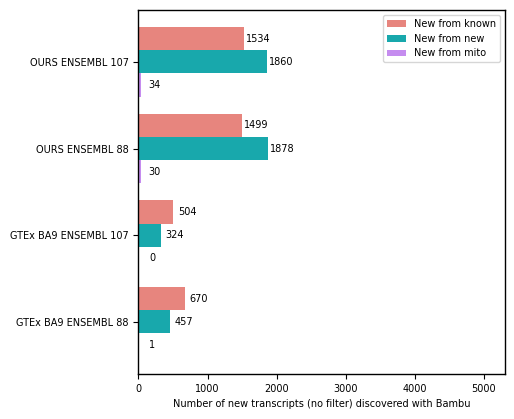

In [44]:
## Make no filter countsplot and save

ax = sns.countplot(y='source', hue='Type', data=df_all, orient='h',
                  palette=[ggplot2_colors[6], ggplot2_colors[4], ggplot2_colors[0]],
                  hue_order=["New from mito", "New from new", "New from known"])


plt.xlim(0,5300)
plt.ylim(-0.6, 3.6)

# Adding labels to each bar
for p in ax.patches:
    
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(10, 0), 
                textcoords='offset points',
                fontsize=7)
    
# Create a new legend with the reordered label and handle
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="upper right")

plt.ylabel("")
plt.xlabel("Number of new transcripts (no filter) discovered with Bambu")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu_BA9/barplot_no_filter_OURS_and_GTEx.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

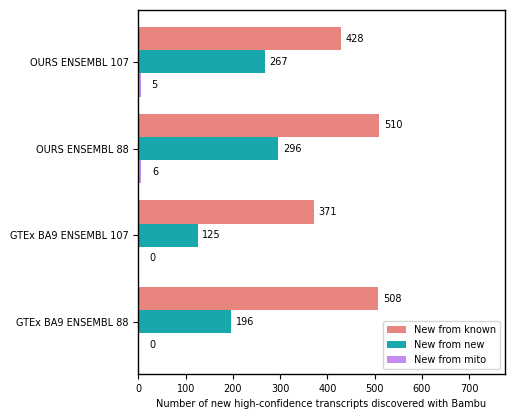

In [45]:
## Make HF countsplot and save

ax = sns.countplot(y='source', hue='Type', data=df_hf, orient='h',
                  palette=[ggplot2_colors[6], ggplot2_colors[4], ggplot2_colors[0]],
                  hue_order=["New from mito", "New from new", "New from known"])


plt.xlim(0,775)
plt.ylim(-0.6, 3.6)

# Adding labels to each bar
for p in ax.patches:
    
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(10, 0), 
                textcoords='offset points',
                fontsize=7)
        
    
# Create a new legend with the reordered label and handle
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="lower right")

plt.ylabel("")
plt.xlabel("Number of new high-confidence transcripts discovered with Bambu")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu_BA9/barplot_high_confidence_OURS_and_GTEx.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [46]:
## Only look at GTEx data
df_all_only_GTEx = df_all.loc[df_all["source"].str.startswith("GTEx")].copy()
df_hf_only_GTEx = df_hf.loc[df_hf["source"].str.startswith("GTEx")].copy()

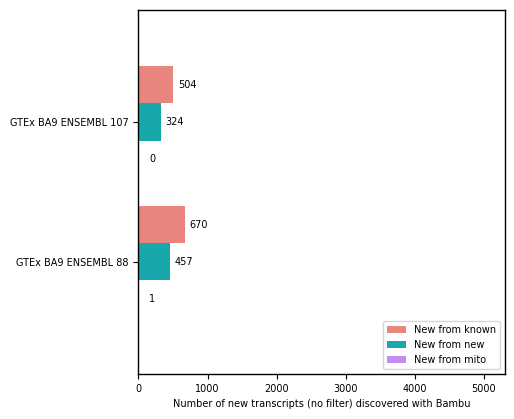

In [47]:
## Make no filter countsplot and save

ax = sns.countplot(y='source', hue='Type', data=df_all_only_GTEx, orient='h',
                  palette=[ggplot2_colors[6], ggplot2_colors[4], ggplot2_colors[0]],
                  hue_order=["New from mito", "New from new", "New from known"])


plt.xlim(0,5300)
plt.ylim(-0.8, 1.8)

# Adding labels to each bar
for p in ax.patches:
    
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(10, 0), 
                textcoords='offset points',
                fontsize=7)
    
# Create a new legend with the reordered label and handle
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="lower right")

plt.ylabel("")
plt.xlabel("Number of new transcripts (no filter) discovered with Bambu")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu_BA9/barplot_no_filter_GTEx.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

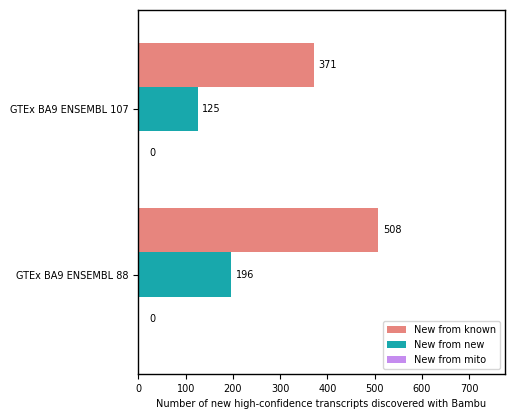

In [48]:
## Make HF countsplot and save

ax = sns.countplot(y='source', hue='Type', data=df_hf_only_GTEx, orient='h',
                  palette=[ggplot2_colors[6], ggplot2_colors[4], ggplot2_colors[0]],
                  hue_order=["New from mito", "New from new", "New from known"])


plt.xlim(0,775)
plt.ylim(-0.6, 1.6)

# Adding labels to each bar
for p in ax.patches:
    
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(10, 0), 
                textcoords='offset points',
                fontsize=7)
        
    
# Create a new legend with the reordered label and handle
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="lower right")

plt.ylabel("")
plt.xlabel("Number of new high-confidence transcripts discovered with Bambu")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu_BA9/barplot_high_confidence_GTEx.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [49]:
## Show all GTEx at once

df_hf_only_GTEx["source"] = df_hf_only_GTEx["source"] + " - high-confidence"
df_all_only_GTEx["source"] = df_all_only_GTEx["source"] + " - all (no filter)"


df_GTEx = pd.concat([df_all_only_GTEx, df_hf_only_GTEx])

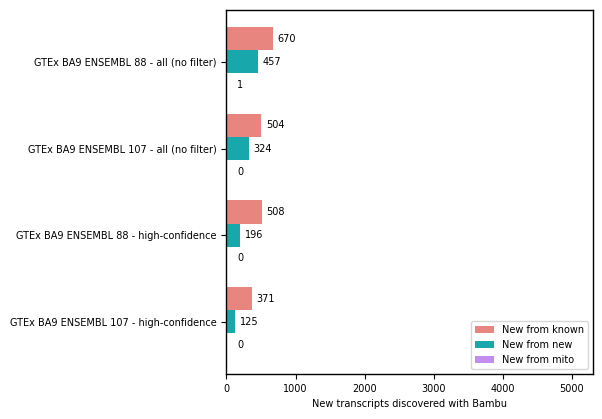

In [50]:
## Make no filter countsplot and save

ax = sns.countplot(y='source', hue='Type', data=df_GTEx, orient='h',
                  palette=[ggplot2_colors[6], ggplot2_colors[4], ggplot2_colors[0]],
                  hue_order=["New from mito", "New from new", "New from known"],
                  order=["GTEx BA9 ENSEMBL 107 - high-confidence", "GTEx BA9 ENSEMBL 88 - high-confidence",
                        "GTEx BA9 ENSEMBL 107 - all (no filter)", "GTEx BA9 ENSEMBL 88 - all (no filter)"])

plt.xlim(0,5300)
plt.ylim(-0.6, 3.6)

# Adding labels to each bar
for p in ax.patches:
    
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(10, 0), 
                textcoords='offset points',
                fontsize=7)
    
# Create a new legend with the reordered label and handle
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="lower right")

plt.ylabel("")
plt.xlabel("New transcripts discovered with Bambu")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu_BA9/barplot_high_confidence_and_all_GTEx.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Make output GTFs

In [51]:
## Import and parse through extended annotations
ref_gtex_88 = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-88_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_gtex_88 = ref_gtex_88.loc[~ref_gtex_88["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_gtex_88 = parse_df_columns(ref_gtex_88, is_ref=False, delete_other=False)

## Only keep transcripts
ref_gtex_88_new_all = ref_gtex_88.loc[ref_gtex_88["transcript_id"].isin(df_counts_gtex_88_all_ids)].copy()

## Drop useless columns after filtering
ref_gtex_88_new_all.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

## Save output
ref_gtex_88_new_all.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu_BA9/GTEx_BA9_ENSEMBL_88_NEW_ALL.gtf",
                          header=False, index=False, quoting=csv.QUOTE_NONE, sep="\t")

In [52]:
## Import and parse through extended annotations
ref_gtex_107 = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_gtex_107 = ref_gtex_107.loc[~ref_gtex_107["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_gtex_107 = parse_df_columns(ref_gtex_107, is_ref=False, delete_other=False)

## Only keep transcripts
ref_gtex_107_new_all = ref_gtex_107.loc[ref_gtex_107["transcript_id"].isin(df_counts_gtex_107_all_ids)].copy()

## Drop useless columns after filtering
ref_gtex_107_new_all.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

## Save output
ref_gtex_107_new_all.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu_BA9/GTEx_BA9_ENSEMBL_107_NEW_ALL.gtf",
                          header=False, index=False, quoting=csv.QUOTE_NONE, sep="\t")

In [53]:
## Import and parse through extended annotations
ref_ours_88 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-88_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_ours_88 = ref_ours_88.loc[~ref_ours_88["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_ours_88 = parse_df_columns(ref_ours_88, is_ref=False, delete_other=False)

## Only keep transcripts
ref_ours_88_new_all = ref_ours_88.loc[ref_ours_88["transcript_id"].isin(df_counts_ours_88_all_ids)].copy()

## Drop useless columns after filtering
ref_ours_88_new_all.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

## Save output
ref_ours_88_new_all.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu_BA9/OURS_ENSEMBL_88_NEW_ALL.gtf",
                          header=False, index=False, quoting=csv.QUOTE_NONE, sep="\t")

In [54]:
## Import and parse through extended annotations
ref_ours_107 = pd.read_csv("../../../data/raw/1st_rebuttal_data/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_ours_107 = ref_ours_107.loc[~ref_ours_107["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_ours_107 = parse_df_columns(ref_ours_107, is_ref=False, delete_other=False)

## Only keep transcripts
ref_ours_107_new_all = ref_ours_107.loc[ref_ours_107["transcript_id"].isin(df_counts_ours_107_all_ids)].copy()

## Drop useless columns after filtering
ref_ours_107_new_all.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

## Save output
ref_ours_107_new_all.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu_BA9/OURS_ENSEMBL_107_NEW_ALL.gtf",
                          header=False, index=False, quoting=csv.QUOTE_NONE, sep="\t")

In [55]:
## Import and parse through extended annotations
ref_gtex_88 = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-88_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_gtex_88 = ref_gtex_88.loc[~ref_gtex_88["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_gtex_88 = parse_df_columns(ref_gtex_88, is_ref=False, delete_other=False)

## Only keep transcripts
ref_gtex_88_new_hf = ref_gtex_88.loc[ref_gtex_88["transcript_id"].isin(df_counts_gtex_88_hf_ids)].copy()

## Drop useless columns after filtering
ref_gtex_88_new_hf.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

## Save output
ref_gtex_88_new_hf.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu_BA9/GTEx_BA9_ENSEMBL_88_NEW_HF.gtf",
                          header=False, index=False, quoting=csv.QUOTE_NONE, sep="\t")

In [56]:
## Import and parse through extended annotations
ref_gtex_107 = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_BA9_with_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_gtex_107 = ref_gtex_107.loc[~ref_gtex_107["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_gtex_107 = parse_df_columns(ref_gtex_107, is_ref=False, delete_other=False)

## Only keep transcripts
ref_gtex_107_new_hf = ref_gtex_107.loc[ref_gtex_107["transcript_id"].isin(df_counts_gtex_107_hf_ids)].copy()

## Drop useless columns after filtering
ref_gtex_107_new_hf.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

## Save output
ref_gtex_107_new_hf.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu_BA9/GTEx_BA9_ENSEMBL_107_NEW_HF.gtf",
                          header=False, index=False, quoting=csv.QUOTE_NONE, sep="\t")

In [57]:
## Import and parse through extended annotations
ref_ours_88 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-88_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_ours_88 = ref_ours_88.loc[~ref_ours_88["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_ours_88 = parse_df_columns(ref_ours_88, is_ref=False, delete_other=False)

## Only keep transcripts
ref_ours_88_new_hf = ref_ours_88.loc[ref_ours_88["transcript_id"].isin(df_counts_ours_88_hf_ids)].copy()

## Drop useless columns after filtering
ref_ours_88_new_hf.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

## Save output
ref_ours_88_new_hf.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu_BA9/OURS_ENSEMBL_88_NEW_HF.gtf",
                          header=False, index=False, quoting=csv.QUOTE_NONE, sep="\t")

In [58]:
## Import and parse through extended annotations
ref_ours_107 = pd.read_csv("../../../data/raw/1st_rebuttal_data/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

## Take away ERCCs
ref_ours_107 = ref_ours_107.loc[~ref_ours_107["chr"].str.startswith("ERCC-")].copy()

## Parse
ref_ours_107 = parse_df_columns(ref_ours_107, is_ref=False, delete_other=False)

## Only keep transcripts
ref_ours_107_new_hf = ref_ours_107.loc[ref_ours_107["transcript_id"].isin(df_counts_ours_107_hf_ids)].copy()

## Drop useless columns after filtering
ref_ours_107_new_hf.drop(columns=["gene_id", "transcript_id", "exon_number"], inplace=True)

## Save output
ref_ours_107_new_hf.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu_BA9/OURS_ENSEMBL_107_NEW_HF.gtf",
                          header=False, index=False, quoting=csv.QUOTE_NONE, sep="\t")